In [21]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [36]:
# Get data - download data from Yahoo! Finance, for now we focus on a single stock 'AAPL'. 
# In later versions we will focus on selected set from NASDAQ or SP500.

def get_data(ticker: str, start_date: datetime.datetime, end_date: datetime.datetime):
    
    # yfinance returns pandas dataframe
    data_df = yf.download(ticker, start=start_date, end=end_date)
    return data_df
 
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2023, 10, 1)
stock_df = get_data('AAPL', start_date=start_date, end_date=end_date)

[*********************100%%**********************]  1 of 1 completed


In [38]:
# Data preparation and feature engineering - main focus for now is logarithmic return and market microstructure factors (volatility, volume)
# In later versions we might consider technical indicators (RSI, Bollinger bands, SMA, EMA)

def feature_engineering(data: pd.DataFrame):
    
    # Compute stock logarithmic returns
    data['log_return_1d'] = np.log(data['Adj Close']).diff()
    
    # Compute volatilities from returns: we might want to have volatility for different time windows
    def calc_volatility(log_return: pd.Series, trading_window: int):
        volatility = log_return.rolling(trading_window).std()*np.sqrt(trading_window)
        return volatility

    data['volatility_1w'] = calc_volatility(data['log_return_1d'], 5) # weekly volatility
    data['volatility_1m'] = calc_volatility(data['log_return_1d'], 20) # monthly volatility
    
    # Compute volumes, volume for a given day is already provided by yfinance
    def calc_volume(volume: pd.Series, trading_window: int):
        volume = volume.rolling(trading_window).std()*np.sqrt(trading_window)
        return volume
    
    data['volume_1w'] = calc_volume(data['Volume'], 5) # weekly volume
    data['volume_1m'] = calc_volume(data['Volume'], 20) # monthly volume
    
    return data
    
data_df = feature_engineering(stock_df)
data_df = data_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1).dropna(axis=0) # drop columns, drop rows with NaN

In [42]:
# View data

print('DataFrame shape')
print(data_df.shape)
print('---------------------------')
print('DataFrame head:')
print(data_df.head())
print('---------------------------')
print('DataFrame information:')
print(data_df.info())
print('---------------------------')
print('DataFrame statistics')
print(data_df.describe())

DataFrame shape
(1929, 6)
---------------------------
DataFrame head:
            Adj Close  log_return_1d  volatility_1w  volatility_1m  \
Date                                                                 
2016-02-02  21.531818      -0.020429       0.084309       0.121459   
2016-02-03  21.957979       0.019599       0.048775       0.122015   
2016-02-04  22.134415       0.008003       0.048803       0.121203   
2016-02-05  21.543251      -0.027071       0.043517       0.116412   
2016-02-08  21.770098       0.010475       0.045966       0.116823   

               volume_1w     volume_1m  
Date                                    
2016-02-02  3.491511e+08  3.631347e+08  
2016-02-03  9.918371e+07  3.690128e+08  
2016-02-04  9.320368e+07  3.746091e+08  
2016-02-05  3.678721e+07  3.713384e+08  
2016-02-08  5.280693e+07  3.697916e+08  
---------------------------
DataFrame information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1929 entries, 2016-02-02 to 2023-09-29
Data colu

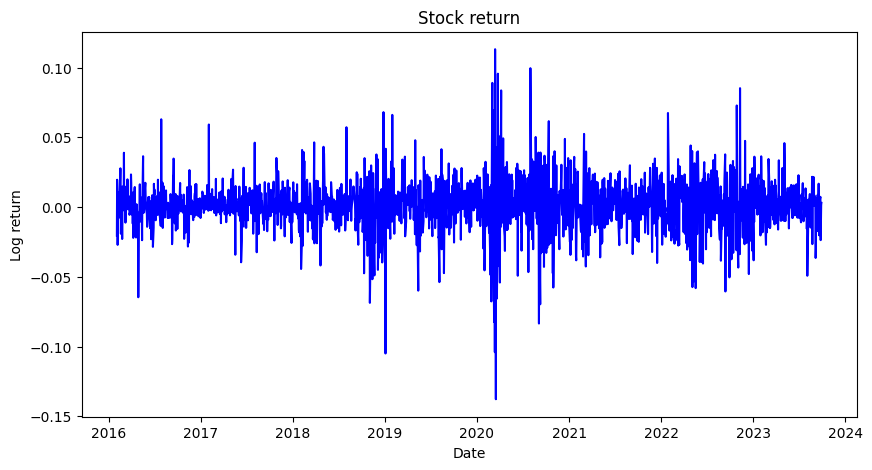

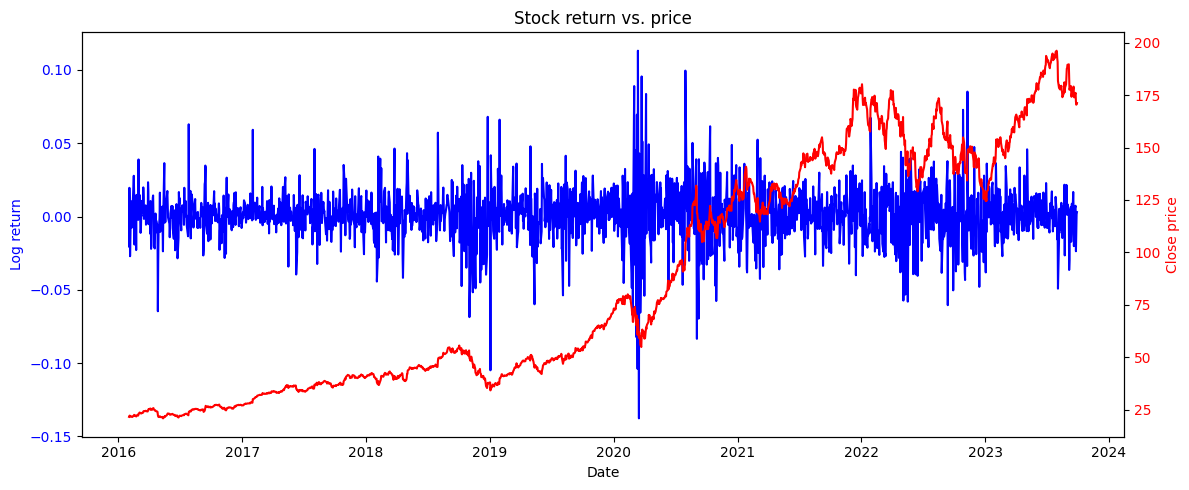

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

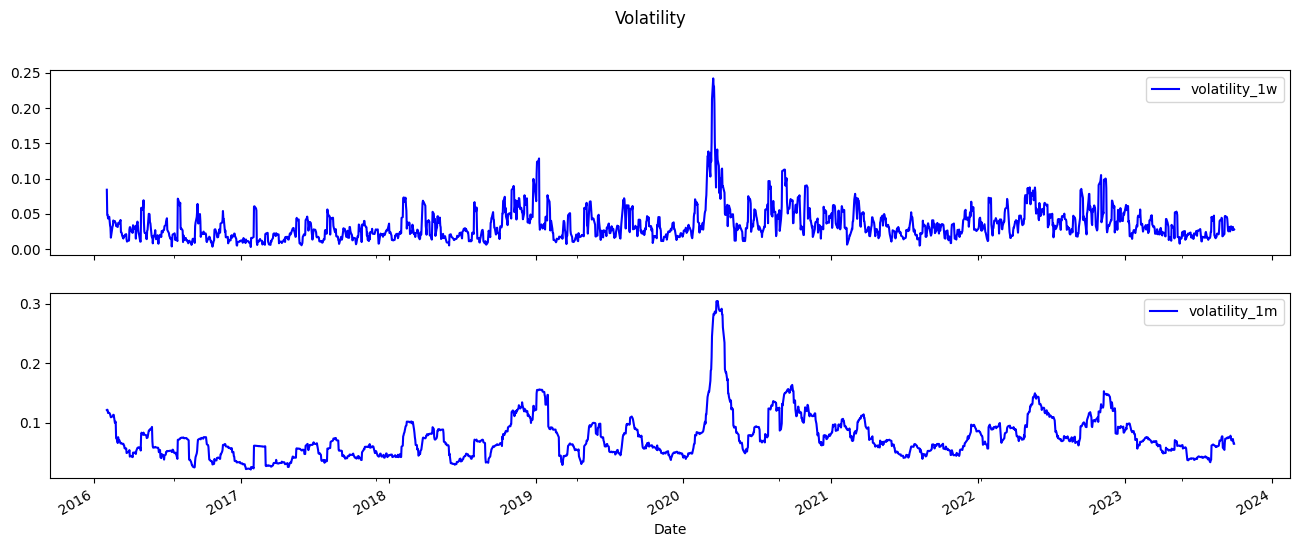

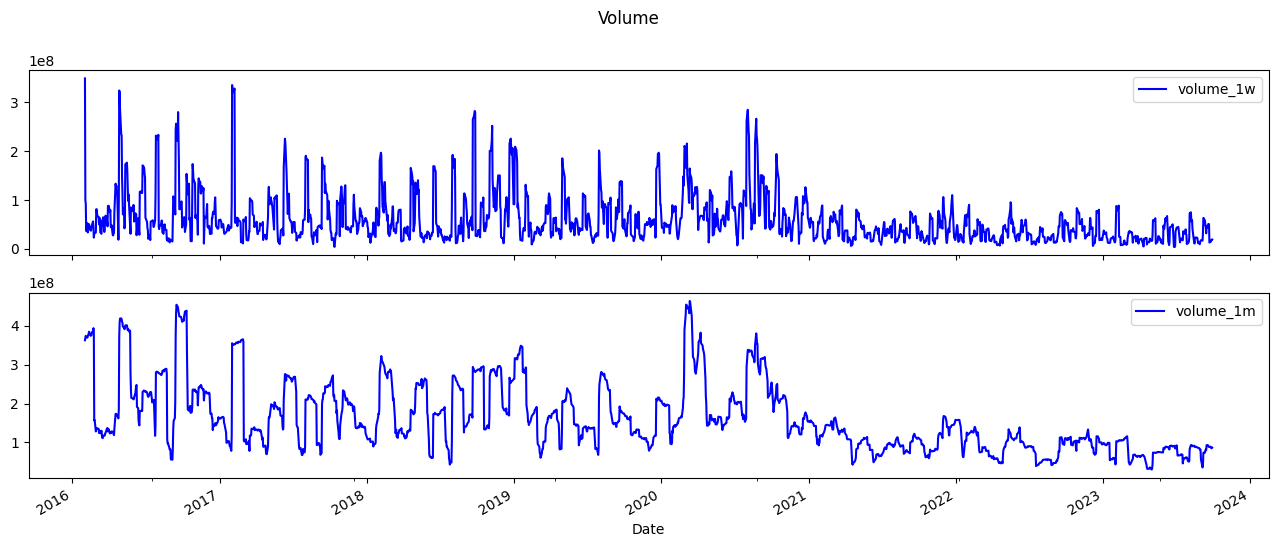

In [103]:
# Plot data

# Plot logarithmic returns
plt.figure(figsize=(10, 5))
plt.plot(data_df['log_return_1d'], color='blue')
plt.title('Stock return')
plt.xlabel('Date')
plt.ylabel('Log return')
                 
# Plot logarithmic returns with adjusted close price
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
plt.title('Stock return vs. price')
color1 = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Log return', color=color1)
ax1.plot(data_df['log_return_1d'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
color2='red'
ax2.set_ylabel('Close price', color=color2)
ax2.plot(data_df['Adj Close'], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
fig.tight_layout() 
plt.show()
                 
# Plot volatilities
data_df.iloc[:,2:4].plot(subplots=True, color='blue', figsize=(16, 6), title='Volatility')

# Plot volumes
data_df.iloc[:,4:6].plot(subplots=True, color='blue', figsize=(16, 6), title='Volume')

NEW CODE

----------------------------------------------

OLD CODE

In [ ]:
tf.random.set_seed(7)

In [222]:
# Split data into train and test sets
data = stock_data['log_return'].values
train_data, test_data = train_test_split(data, test_size=0.20, random_state=1) #random_state seed for splitting, set to any number

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.fit_transform(test_data.reshape(-1, 1))

In [223]:
# Create datasets for train and test data
def create_dataset(dataset, loopback):
    x, y = [], []
    for i in range(loopback, len(dataset)):
        x.append(dataset[i-loopback:i, 0])
        y.append(dataset[i, 0])
    return x, y

x_train, y_train = create_dataset(train_data, 1)
x_test, y_test = create_dataset(test_data, 1)
    
x_train, y_train, x_test= np.array(x_train), np.array(y_train), np.array(x_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [229]:
# LSTM model
model = keras.Sequential()
model.add(layers.LSTM(200, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='tanh'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [230]:
# Fit model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(x_train, y_train, batch_size= 1, epochs=1)

1558/1558 [==============================] - 6s 3ms/step - loss: 0.7593 - accuracy: 0.0013


In [231]:
# Predict test data and error
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
#print(prediction)
err = np.sqrt(mean_squared_error(prediction[:30], y_test[:30]))

print(err)

13/13 [==============================] - 0s 3ms/step
0.5605299519111611


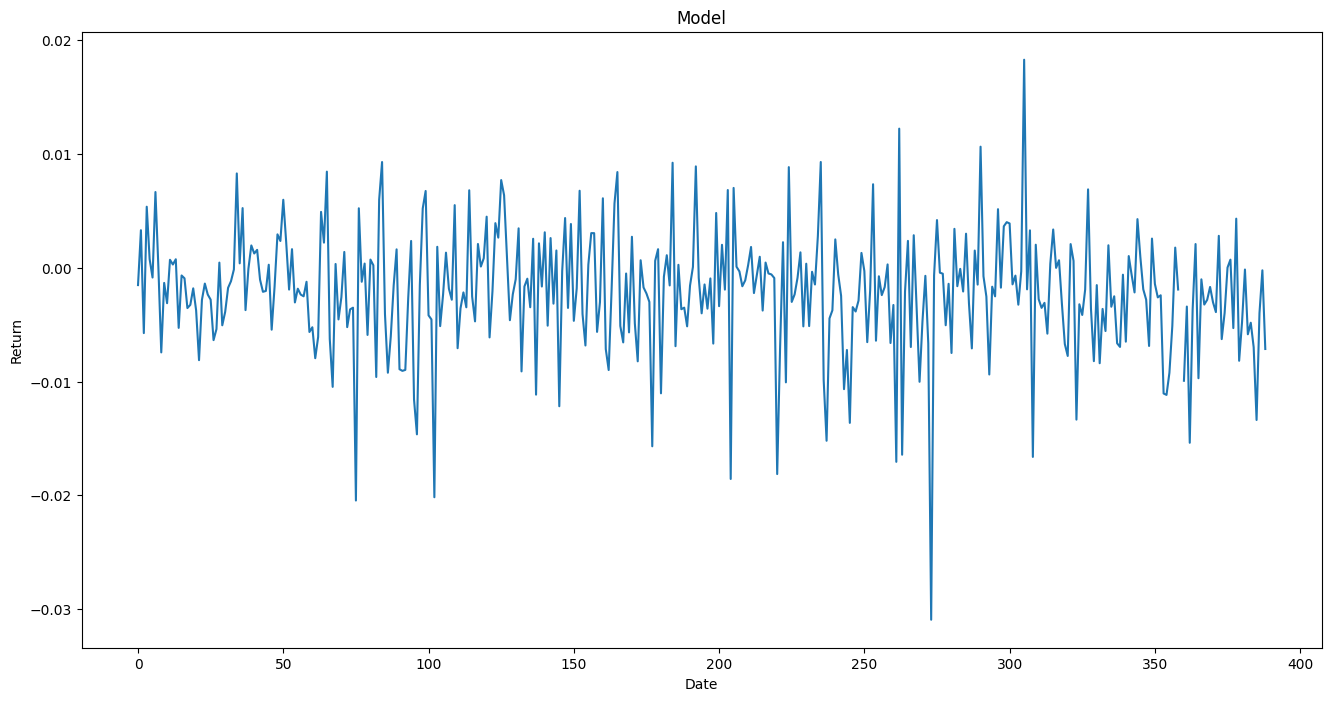

In [232]:
# Plot prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(prediction)

C:\Users\piotr\AppData\Local\Temp\ipykernel_12776\2069691230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=prediction


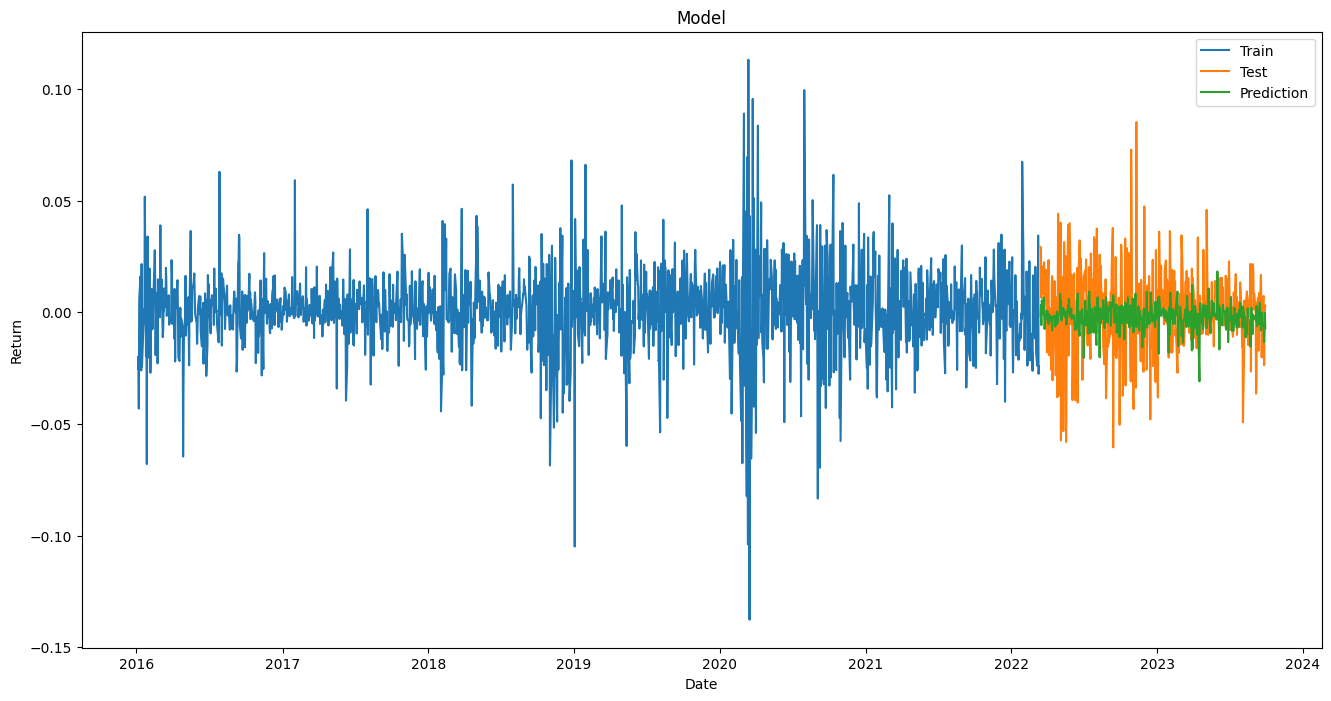

In [233]:
# Compare prediction with test data 
data = stock_data.filter(['log_return'])
train = data[:len(train_data)]
test = data[len(train_data)+1:]
test['Prediction']=prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(train)
plt.plot(test)
plt.legend(['Train', 'Test', 'Prediction'])
plt.show()